# RISM - A Gentle Introduction

## Preamble

The code we've written so far:

In [369]:
import numpy as np
from scipy.fftpack import dstn, idstn
import matplotlib.pyplot as plt

r = 15.0
N = 100
dr = r / N

dk = 2.0 * np.pi / (2.0 * N * dr)

r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

def RISM(cr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    for l in np.arange(0, N): # loop over grid points and perform matmuls for the corresponding matrices
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur, wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the L^2 norm between iterates
        norm = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))

        # Test if the difference is below our tolerance
        if norm < tolerance:
            print("Final Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

## Nitrogen - Introducing Molecular Liquids and the Coulomb Potential

We want to look at more than just simple Lennard-Jones fluids. We can consider an uncharged homonuclear diatomic molecule, and nitrogen is a good such example.
This is an example problem taken from Hirata and Rossky's work on the Extended RISM formalism which introduced an effective way to incorporate electrostatic interactions into RISM ([Hirata et al. J. Chem. Phys. 1982](https://doi.org/10.1063/1.443606)).


Lets define the parameters, system and units.

In [370]:
T = 72.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta
ns = 2 # Number of sites

n2_epsilon = 44.0 * 8.314462618e-3 # kJ / mol
n2_sigma = 3.341 # Angstrom
n2_density = 0.01867 # 1 / Angstrom^3
n2_bond_length = 1.1 # Angstrom

n2_rho = np.diag([n2_density, n2_density])

Notice that we've defined a bond length here. We need this for computing the $\omega(k)$.

First, we need to define what the intramolecular correlation function looks like $$\omega_{ij}(k) = \delta_{ij} + (1 - \delta_{ij})\frac{\sin(kd_{ij})}{kd_{ij}}$$
where $\delta_{ij}$ is the Kronecker delta, and $d_{ij}$ is the distance between site $i$ and $j$.


For nitrogen, we can explicitly define these for each $ij$ pair. If we number both nitrogens as $\textrm{N}_1$ and $\textrm{N}_2$ and we state the bond length between them to be $1.1\, Å$ then we can write 

$$\omega_{\textrm{N}_1 \textrm{N}_1} = \omega_{\textrm{N}_2 \textrm{N}_2} = 1$$

$$\omega_{\textrm{N}_1 \textrm{N}_2} = \omega_{\textrm{N}_2 \textrm{N}_1} = \frac{\sin(1.1k)}{1.1k}$$

In [371]:
n2_wk = np.zeros((N, ns, ns))

# [:, 0, 0] indicates a slice over the first axis (which we defined as the number of points above, and indexing the last 2 axes explicitly with 0 and 0 (or 1 and 1) etc.
n2_wk[:, 0, 0] = n2_wk[:, 1, 1] = np.ones(N)
n2_wk[:, 0, 1] = n2_wk[:, 1, 0] = np.sin(k_grid * n2_bond_length) / k_grid / n2_bond_length

We can compute the potential in a similar fashion

In [372]:
n2_ur = np.zeros((N, ns, ns))

n2_ur[:, 0, 0] = n2_ur[:, 0, 1] = n2_ur[:, 1, 0] = n2_ur[:, 1, 1] = LJ(n2_epsilon, n2_sigma, r_grid)

We can do it like this because the two interaction sites are essentially equivalent, they have the exact same LJ parameters and charge, even if they are in different positions in space. We've accounted for the spatial difference with $\omega(k)$.

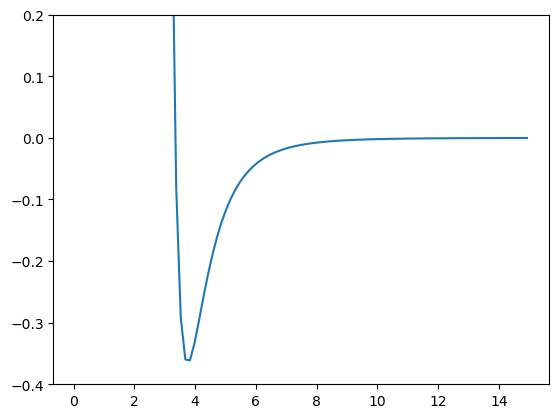

In [373]:
plt.plot(r_grid, n2_ur[:, 0, 0])
plt.ylim([-0.4, 0.2])
plt.show()

For this problem we want to use a different closure. We'd like to use the Percus-Yevick closure instead which is equivalent to setting the bridge function as $B(r) = \ln(1 + t(r))$ yielding the closure $$c(r) = e^{-\beta u(r)}(1 + t(r)) - t(r) - 1$$

In [374]:
def PY(beta, ur, tr):
    return np.exp(-beta * ur) * (1.0 + tr) - 1.0 - tr

We should also refactor our `picard_iteration` function to be able to take arbitrary closures as a function, assuming that the function always takes `beta`, `ur` and `tr` as arguments. 

This isn't a particularly safe way to write this code (what if we implement a closure that takes more than those 3 arguments?), but for our purposes this will be sufficient.

In [375]:
def picard_iteration(closure, tolerance, max_step, alpha, initial_tr, beta, ur, wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = closure(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the L^2 norm between iterates
        norm = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))

        # Test if the difference is below our tolerance
        if norm < tolerance:
            print("Final Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

         # If any value is nan then the solver has diverged
        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

In [376]:
tolerance = 1e-7
max_step = 10000
alpha = 0.2
initial_tr = np.zeros((N, ns, ns))
lambdas = 2

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print("Current Lambda: ", lam)
    tr = picard_iteration(PY, tolerance, max_step, alpha, initial_tr, beta, lam * n2_ur, n2_wk, n2_rho)
    initial_tr = tr

cr = PY(beta, n2_ur, tr)

Current Lambda:  0.5
Iteration: 0 Norm: 8.56e+00
Iteration: 100 Norm: 2.89e-02
Iteration: 200 Norm: 5.70e-03


Iteration: 300 Norm: 1.21e-03
Iteration: 400 Norm: 2.60e-04
Iteration: 500 Norm: 5.62e-05
Iteration: 600 Norm: 1.21e-05
Iteration: 700 Norm: 2.62e-06
Iteration: 800 Norm: 5.66e-07
Iteration: 900 Norm: 1.22e-07
Final Iteration: 914 Norm: 9.86e-08
Current Lambda:  1.0
Iteration: 0 Norm: 6.11e+00
Iteration: 100 Norm: 6.03e-03
Iteration: 200 Norm: 1.68e-03
Iteration: 300 Norm: 4.77e-04
Iteration: 400 Norm: 1.36e-04
Iteration: 500 Norm: 3.88e-05
Iteration: 600 Norm: 1.11e-05
Iteration: 700 Norm: 3.16e-06
Iteration: 800 Norm: 9.03e-07
Iteration: 900 Norm: 2.58e-07
Final Iteration: 976 Norm: 9.95e-08


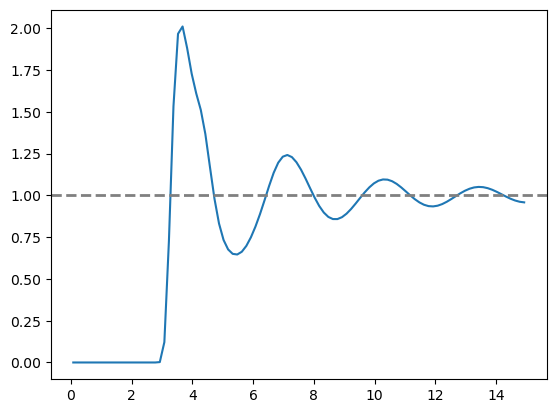

In [377]:
hr = tr + cr

gr = hr + 1.0

plt.plot(r_grid, gr[:, 0, 0])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.show()

Notice that we've only plotted one of the 4 radial distribution functions we've calculated. We can plot the rest but we'll find that they're all the same!

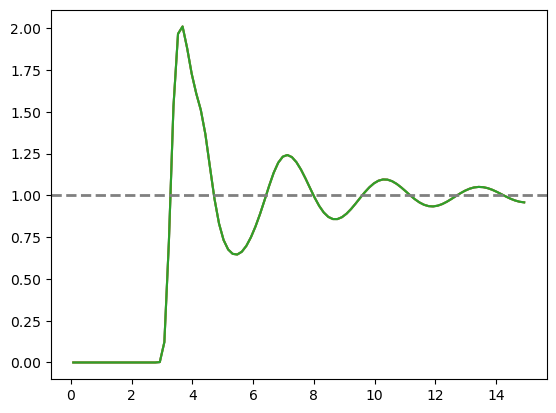

In [378]:
plt.plot(r_grid, gr[:, 0, 1])
plt.plot(r_grid, gr[:, 1, 0])
plt.plot(r_grid, gr[:, 1, 1])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.show()

The reason for this is that in the uncharged molecule, all the sites are essentially equivalent. They both have the same interactions with the bulk liquid and so their distributions will be the same.

We want to model a charged homonuclear diatomic system too, i.e. the above nitrogen molecule but with a charge on each atom. We also want to test that we've implemented our code correctly.

Hirata et al. in their original paper noted that the sum of the radial distribution functions in the charged model (which we define as $g^{+-}$ and $g^{++}$. We could also consider $g^{-+}$ and $g^{--}$. Again, due to some of the sites being equivalent, $g^{+-} = g^{-+}$ and $g^{++} = g^{--}$) is equal to twice the radial distribution function (which we define as $g^*$) $$ 2g^* = g^{+-} + g^{++} $$

We can use this as a twice to verify the correctness of our implementation. We'll save the $g(r)$ we've just computed into a variable named `gn`

In [379]:
gn = gr[:, 0, 0]

Now, we need to introduce the long-range interactions introduced by the charges.

In order to do that, we need to be able to properly model the long-range electrostatics via the Coulomb potential.

A problem that arises is properly dealing with the long-range part when performing a Fourier transform - the potential will diverge!

A simple solution is to split the potential energy into two parts - a short and long range component.
Perform the fast Fourier transform on the short range component but choose the long-range component such that we can analytically transform it.

We will choose such a form in a moment, first we should define the model we want to solve.

The model is essentially the same as before but we introduce a chage of $0.2\, e$ and $-0.2\, e$ on each nitrogen atom.

In [380]:
T = 72.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

n2_epsilon = 44.0 * 8.314462618e-3 # kJ / mol
n2_sigma = 3.341 # Angstroms
n2_density = 0.01867 # 1 / Angstroms^3

n2_charge = 0.2 #ec

n2_rho = np.diag([n2_density, n2_density])

We need to implement the Coulomb potential, which is simply $$ U_{\text{Coulomb}}(r) = \frac{q_1 q_2}{r} $$

We do need to make sure the units are correct, we want the energy to be in kJ/mol. $$ C = \frac{e^2 \text{Na}}{4 \pi \epsilon_0} \times10^{-7} $$

where

$e = 1.602176565\times10^{-19}\, A \cdot s\\ \epsilon_0 = 8.854187817620\times10^{-12}\, \frac{A^2 \cdot s^4}{kg \cdot m^3}\\ \text{Na} = 6.02214129\times10^{23}\, \frac{1}{\text{mol}}$ 

and the $10^{-7}$ factor is to convert from meters to angstroms.

In [381]:
ec = 1.602176565e-19 # A*s
eps_0 = 8.854187817620e-12 # A^2*s^4/kg/m^3
Na = 6.02214129e23 # 1 / mol
kc = 1.0 / 4.0 / np.pi / eps_0 # J*m/A^2/s^2
kc_a = kc * 1e10 # J*angstrom/A^2/s^2
kc_akj = kc_a * 1e-3 # kJ*angstrom/A^2/s^2
kc_akjmol = kc_akj * Na # kJ*angstrom/A^2/s^2/mol
c = ec * ec * kc_akjmol # kJ*angstrom/mol

def Coulomb(q, r):
    return c * q / r

We use the scheme described by [K.C Ng](https://doi.org/10.1063/1.1682399) to analytically deal with the long-range parts of the potential, in order to avoid divergences introduced by the Coulomb potential. The real-space form of the long-range potential is $$u_{\text{LR}}(r) = \frac{q_1q_2}{r}\text{erf}(r)$$ and the Fourier-space form is $$u_{\text{LR}}(k) = \frac{4 \pi q_1 q_2 }{k^2}\exp\left(\frac{-k^2}{4}\right)$$

If the total potential is $$ u(r) = u_{\text{LJ}}(r) + u_{\text{Coulomb}}(r) $$ then the short-range component is $$ u_{\text{SR}}(r) = u(r) - u_{\text{LR}}(r) $$

In [382]:
from scipy.special import erf

def Ng_real(q, r):
    return c * q * erf(r) / r

def Ng_fourier(q, k):
    return 4.0 * np.pi * c * q * np.exp(-np.power(k, 2.0) / 4.0) / np.power(k, 2.0)


Finally, we tabulate the potential into arrays. Notice again the equivalent sites.

In [383]:
n2_lj = np.zeros((N, ns, ns))
n2_cou = np.zeros((N, ns, ns))
n2_ng_real = np.zeros((N, ns, ns))
n2_ng_fourier = np.zeros((N, ns, ns))

n2_lj[:, 0, 0] = n2_lj[:, 0, 1] = n2_lj[:, 1, 0] = n2_lj[:, 1, 1] = LJ(n2_epsilon, n2_sigma, r_grid) # The Lennard-Jones paramters are all the same

n2_cou[:, 0, 0] = n2_cou[:, 1, 1] = Coulomb(n2_charge * n2_charge, r_grid) # The ++ and -- potentials are the same
n2_cou[:, 0, 1] = n2_cou[:, 1, 0] = Coulomb(-n2_charge * n2_charge, r_grid) # The +- and -+ potentials are the same

n2_ng_real[:, 0, 0] = n2_ng_real[:, 1, 1] = Ng_real(n2_charge * n2_charge, r_grid)
n2_ng_real[:, 0, 1] = n2_ng_real[:, 1, 0] = Ng_real(-n2_charge * n2_charge, r_grid)

n2_ng_fourier[:, 0, 0] = n2_ng_fourier[:, 1, 1] = Ng_fourier(n2_charge * n2_charge, k_grid)
n2_ng_fourier[:, 0, 1] = n2_ng_fourier[:, 1, 0] = Ng_fourier(-n2_charge * n2_charge, k_grid)

We are going to work with $U_{\text{SR}}(r)$ when dealing with the closure but when we get to the integral equation, we want to reintroduce the long-range component in Fourier-space. If we compute the short-range direct correlation function from the closure (using the short-range energy), we can the get the full direct correlation back with $$ c(r)= c_{\text{SR}}(r) - \beta u_{\text{LR}}(r) $$

Once we obtain the new $t(r)$ from the integral equation, we can remove it again with $$ t(r)= t_{\text{SR}}(r) - \beta u_{\text{LR}}(r) $$

Lets refactor the `RISM` function and the `picard_iteration` function to account for this.

In [384]:
def RISM(cr, vk_lr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(closure, tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = closure(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

         # Check the L^2 norm between iterates
        norm = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))

        # Test if the difference is below our tolerance
        if norm < tolerance:
            print("Final Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        # If any value is nan then the solver has diverged
        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

Lets compute the potentials we need

In [385]:
n2_ur = n2_lj + n2_cou
n2_ur_sr = n2_ur - n2_ng_real

and start the solver...

In [386]:
tolerance = 1e-7
max_step = 10000
alpha = 0.2
initial_tr = np.zeros((N, ns, ns))
lambdas = 1

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print("Current Lambda: ", lam)
    tr = picard_iteration(PY, tolerance, max_step, alpha, initial_tr, beta, lam * n2_ur_sr, lam * n2_ng_fourier, n2_wk, n2_rho)
    initial_tr = tr

cr = PY(beta, n2_ur_sr, tr) - beta * n2_ng_real
tr += beta * n2_ng_real

Current Lambda:  1.0
Iteration: 0 Norm: 5.91e+00
Iteration: 100 Norm: 1.92e-01


Iteration: 200 Norm: 1.52e-01
Iteration: 300 Norm: 1.25e-01
Iteration: 400 Norm: 9.68e-02
Iteration: 500 Norm: 7.06e-02
Iteration: 600 Norm: 4.83e-02
Iteration: 700 Norm: 3.11e-02
Iteration: 800 Norm: 1.92e-02
Iteration: 900 Norm: 1.14e-02
Iteration: 1000 Norm: 6.66e-03
Iteration: 1100 Norm: 3.84e-03
Iteration: 1200 Norm: 2.20e-03
Iteration: 1300 Norm: 1.25e-03
Iteration: 1400 Norm: 7.12e-04
Iteration: 1500 Norm: 4.04e-04
Iteration: 1600 Norm: 2.29e-04
Iteration: 1700 Norm: 1.30e-04
Iteration: 1800 Norm: 7.35e-05
Iteration: 1900 Norm: 4.17e-05
Iteration: 2000 Norm: 2.36e-05
Iteration: 2100 Norm: 1.34e-05
Iteration: 2200 Norm: 7.57e-06
Iteration: 2300 Norm: 4.29e-06
Iteration: 2400 Norm: 2.43e-06
Iteration: 2500 Norm: 1.38e-06
Iteration: 2600 Norm: 7.80e-07
Iteration: 2700 Norm: 4.42e-07
Iteration: 2800 Norm: 2.50e-07
Iteration: 2900 Norm: 1.42e-07
Final Iteration: 2962 Norm: 9.97e-08


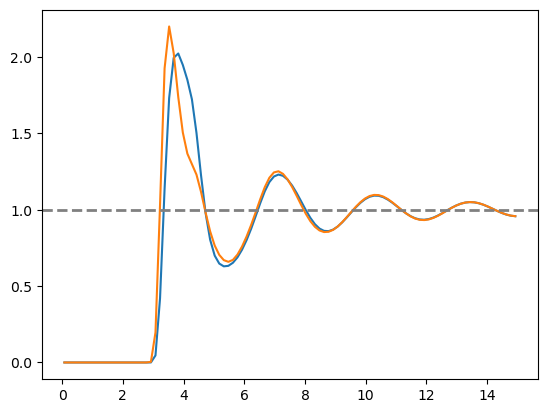

In [387]:
hr = tr + cr

gr = hr + 1.0

plt.plot(r_grid, gr[:, 0, 0])
plt.plot(r_grid, gr[:, 0, 1])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.show()

Now lets verify our result is correct. As we stated before $$ 2g^* = g^{+-} + g^{++} $$
We've saved $g^*$ in `gn`. We'll save $g^{+-}$ and $g^{++}$ in `gpn` and `gpp` respectively and test it with `np.allclose`

In [388]:
gpp = gr[:, 0, 0]
gpn = gr[:, 0, 1]

np.allclose(2 * gn, gpp + gpn, atol=1e-2)

True

We set the absolute tolerance (`atol`) to 0.01 because the original paper reported that the they were within 1% accuracy.
Lets plot $2g^*$ and $g^{+-} + g^{++}$ to see if they match.

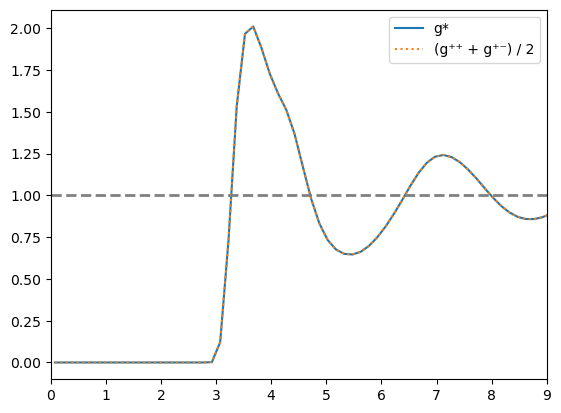

In [389]:
plt.plot(r_grid, gn, label = "g*")
plt.plot(r_grid, (gpp + gpn) / 2.0, linestyle=":", label="(g⁺⁺ + g⁺⁻) / 2")
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.legend()
plt.show()

They do! We've verified that we've implemented the Coulombic interactions and intramolecular correlation function correctly.